# 6. Convolutional Neural Networks

### 6.1 From Dense Layers to Convolutions

The models that were discussed in previous chapters are fine options if yopu are dealing with tabular data. By tabular we mean that the data consists of rows corresponding to examples and columns corresponding to features. With tabular data, we might anticipate that pattern we seek could require modeling interactions among the features, but do not assume anything a priori about which features are related to each other or in what way.

Sometimes we truly may not have any knowledge to guide the construction of more cleverly-organized architectures. In these cases, a multilayer perceptron is often the best that we can do. However, once we start dealing with high-dimensional perceptual data, these *structure-less* networks can grow unwieldy.

For instance, let's return to our running example of distinguishing cats from dogs. Say that we do a thorough job in data collection, collecting an annotated sets of high-quality 1-megapixel photographs. This means that the input into a network has *1 million dimensions* (1-megapixel is 1 million pixels). Even an aggresive reduction to *1,000 hidden dimensions* would require a *dense* (fully-connected) layer to support $10^9$ parameters. Unless we have an extremely large dataset (perhaps billions of photos), lots of GPUs, a talent for extreme distributed optimization, and an extraordinary amount of patience, learning the parameters of this network may turn out to be impossible. 

A careful reader might object to this argument on the basis that 1 megapixel resolution may not be necessary. However, while you could get away with 100,000 pixels, we grossly underestimated the number of hidden nodes that it typically takes to learn good hidden representations of images. Learning a binary classifier with so many parameters might seem to require that we collect an enormous dataset, perhaps comparable to the number of dogs and cats on the planet. And yet both humans and computers are able to distinguish cats from dogs quite well, seemingly contradicting these conclusions. That is because images exhibit rich structure that is typically exploited by humans and machine learning models alike.

#### 6.1.1 Invariances

Imagine that you want to detect an object in an image. It seems reasonable that whatever method we use to recognize objects should not be overly concerned **with the precise *location* of the object**. Ideally, we could learn a system that would somehow exploit this knowledge. Pigs usually don't fly and planes usually do not swim. Nonetheless, we could still recognize a flying pig were one to appear. This idea is taken to the extreme in the children's game "Where's Waldo". The game consists of a number of chaotic scenes bursting with activity and Waldo shows up somewhere in each (typically lurking in some unlikely location). The reader's goal is to locate him. Despite his characteristic outfit, this can be surprisingly difficult, due to the large number of **confounders** 

Back to images, the intuitions we have been discussing could be made more concrete yielding a few key principles for building neural networks for computer vision:

- 1) Our vision systems should, in some sense, respond similarly to the same object **regardless of where it appears in the image** (*translation invariance*)
- 2) Our vision system should, in some sense, focus on **local regions, without regard for what else is happening in the image at greater distances** (*locality*)


#### 6.1.2 Constraining the MLP

To start off, let's consider what an MLP would look like with $h \times w$ images as inputs (represented as matrices in math, and as 2D arrays in code), and hidden representations similarly organized as $h \times w$ / 2D arrays. Let $x[i, j]$ and $h[i, j]$ denote pixel location $(i, j)$ in an image and hidden representation, respectively. Consequently, to have each of the $hw$ hidden nodes receive input from each of the $hw$ inputs, we would switch from using weight matrices (as we did previously in MLPs) to representing our parameters as four-dimensional weight tensors.

We could formally express this dense layer as follows:

$h[i, j] = u[i, j] + \sum{W[i,j,k,l]} * x[k, l] = u[i, j] + \sum{V[i,j,a,b]} * x[i+a, j + b]$

**The switch from W to V is entirely cosmetic (for now) since there is a one-to-one correspondence between coefficients in both tensors**. We simply re-index the subscripts $(k, l)$ such that $k = i + a$ and $l = j + b$. In other words, we set $V[i,j,a,b] = W[i, j, i + a, j + b]$. **The indices $a,b$ run over both positive and negative offsets, covering the entire image. For any given location $(i, j)$ in the hidden layer $h[i, j]$, we compute its value by summing over pixels in $x$, centered around $(i, j)$ and weighted $V[i,j,a,b]$**.

Now, let's invoke the first principle we established above: *translation invariance*. This implies that **a shift in the inputs $x$ should simply lead to a shift in activations $h$**. This is only possible if $V$ and $u$ **DO NOT** actually depend on $(i, j)$, i.e., we have $V[i,j,a,b] = V[a,b]$ and $u$ is a constant. As a result we can simplify the definition for $h$.

$h[i,j] = u + \sum{V[a,b]} * x[i + a, j + b]$

This is a convolution! **We are effectively weighting pixels $(i + a, j + b)$ in the VICINITY of $(i, j)$ with coefficients $V[a,b]$ to obtain the value $h[i,j]$. Note that V[i,j] needs many fewer coefficients than $V[i,j,a,b]$. For a 1 megapixel image it has at most 1 million coefficients**. This is 1 million fewer parameters since it no longer depends on the location within the image. We have made significant progress!

#### 6.1.3 Convolutions

Let's briefly review why the above operation is called a *convolution*. In mathematics, the convolution between two functions, say $f, g: \mathbf{R}^d \rightarrow R$ is defined as:

$[f\circledast{g}](x) = \int_{R^d}f(z)g(x-z)dz$

That is, we measure the overlap between f and g when **both functions are shifted by $x$ and "flipped"**. Whenever we have discrete objects, the integral turns into a sum. For instance, for vectors defined on $l_2$, i.e., the set of square summable infinite dimensional vectors with index running over $Z$ we obtain the following definition.

$[f\circledast{g}](i) = \sum_{a}f(a)g(i-a)$


For two-dimensional arrays, we have a corresponding sum with indices $(i, j)$ for $f$ and $(i - a, j - b)$ for $g$ respectively. This looks similar to the definition above, with one major difference. Rather than using $(i + a, j + b)$, we are using the difference instead. Note, though, that this distinction is mostly cosmetic since we can always match the notation by using $V[a,b] = V[-a, -b]$ to obtain $h = x \circledast V$. Also note that the original definition is actually a *cross correlation*. We will come back to this in the following section.

#### 6.1.4 Waldo Revisited

Let's see what this looks like if we want to build an improved Waldo detector. The convolutional layer picks windows of a given size and weighs intensities **according to the mask V**. **We expect that wherever the "waldoness" is highest, we will also find a peak in the hidden layer activations**

There is just a problem with this approach: so far we blissfully ignored that images consist of 3 channels: red, green, and blue. In reality, images aren't quite two-dimensional objects but **rather a $3^{rd}$ order tensor**, e.g., with shape $1024 \times 1024 \times 3$ pixels. Only two of these axes concern spatial relationships, while the $3^{rd}$ can be regarded as assigning a multidimensional representation to *each pixel location*.

We thus index $\textbf{x}$ as $x[i, j, k]$. The convolutional mask has to adapt accordingly. Instead of $V[a, b]$ we now have $V[a, b, c]$

Moreover, just as our input consists of a $3^{rd}$ order tensor, it turns out to be a good idea to similarly formulate our hidden representations as $3^{rd}$ order tensors. In other words, rather than just having a 1D representation corresponding to each spatial location, we want to have a multidimensional hidden representations corresponding to each spatial location. We could think of the hidden representation as comprising a number of 2D grids stacked on top of each other. These are sometimes called *channels* or *feature maps*. Intuitively you might imagine that at lower layers, some channels specialize at recognizing edges for example. We can take care of this by adding a fourth coordinate to $V$ via $V[a, b, c, d]$.


#### Summary

- Translation invariance in images implies that all patches of an image will be treated in the same manner

- Locality means that only a small neighborhood of pixels will be used for computation

- Channels on input and output allow for meaningful feature analysis.

### 6.2 Convolutions for Images

#### 6.2.1 The Cross-Correlation Operator

In a convolutional layer, an **input array** and a **correlation kernel array** are combined to produce an output array through a cross-correlation operation. Let's see how this works for two dimensions. The input in our example is a 2D array with a height of 3 and width of 3. We mark the shape of the array as $3 \times 3$ or (3,3). The height and width of the kernel array are both 2. Common names for this array in the deep learning community include *kernel* and *filter*. The shape of the kernel window (also known as the convolutional window) is given precisely by the height and width of the kernel (here it is $2 \times 2$)

In [1]:
from mxnet import autograd, np, npx
from mxnet.gluon import nn

npx.set_np()

In [2]:
def corr2d(X, K):
    '''Compute 2D cross-correlation.'''
    h, w = K.shape
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

In [3]:
X = np.array([[0,1,2], 
              [3,4,5], 
              [6,7,8]])
K = np.array([[0, 1], 
              [2, 3]])

In [4]:
corr2d(X, K)

array([[19., 25.],
       [37., 43.]])

In [5]:
K.shape

(2, 2)

#### 6.2.2 Convolutional Layers

A convolutional layer **cross-correlates** the input and kernels and adds a scalar bias to produce an output. The parameters of the convolutional layer are precisely the values that constitute the kernel and the scalar bias. **When training the models based on convolutional layers, we typically initialize the kernels randomly, just as we would with a fully-connected layer.**

We are now ready to implement a 2D-convolutional layer based on the corr2d function defined above. In the `__init__` constructor function, we declare weight and bias as the two model parameters. The forward computation function *forward* calls the corr2d function and adds the bias. As with $h \times w$ cross-correlation we also refer to convolutional layers as $h \times w$ convolutions.

In [6]:
class Conv2D(nn.Block):
    def __init__(self, kernel_size, **kwargs):
        super(Conv2D, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape = kernel_size)
        self.bias = self.params.get('bias', shape = (1,))
        
    def forward(self, x):
        return corr2d(x, self.weight.data()) + self.bias.data()

#### 6.2.3 Object Edge Detection in Images

Let's look at a simple application of a convolutional layer: detecting the edge of an object in an image **by finding the location of the pixel change**. First, we construct an 'image' of $6 \times 8$ pixels. The middle four columns are black (0) and the rest are white (1).

In [7]:
X = np.ones((6,8))

In [8]:
X[:, 2:6] = 0
X

array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]])

Next, we construct a kernel K with a height of 1 and width of 2. When we perform the cross-correlation operation with the input, ***if the horizontally adjacent elements are the same, the output is zero***. Otherwise, the output is non-zero.

In [9]:
K = np.array([[1, -1]])
K_2 = np.array([[1],
                [-1]])

Enter X and our designed kernel K to perform the cross-correlation operations. As you can see, we will detect 1 for the edge from white to black and -1 for the edge from black to white. The rest of the outputs are 0. 

In [10]:
Y = corr2d(X, K)
Y

array([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

Let's apply the kernel to the transposed image. As expected, it vanishes. **The kernel K only detects vertical edges.**


*Note*: What would happen if I were to transpose the kernel so that it is represented as a column vector? (2 x 1 in this case)

Answer: It would work correctly, i.e. the result would be the transpose of Y (that is calculated above)

In [11]:
corr2d(X.T, K_2)

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

#### 6.2.4 Learning a Kernel

Designing an edge detector by finite differences [1, -1] is neat if we know this is precisely what we are looking for. However, as we look at larger kernels, and consider successive layers of convolutions, it might be impossible to specify precisely what each filter should be doing manually. 

Now, let's see whether we can **learn the kernel** that generated Y from X by looking at the (input, output) pairs only. We first construct a convolutional layer and initialize its kernel as a random array. Next, in each iteration, we will use the **squared error to compare Y and the output of the convolutional layer, then calculate the gradient to update the weight**. For the sake of simplicity, in this convolutional layer, we will ignore the bias.

We previously constructed the Conv2D class. However, since we used single-element assignments, Gluon has some trouble finding the gradient. Instead, we use the built-in Conv2D class provided by Gluon.

In [18]:
# Construct a convolutional layer with 1 output channel
# (channels will be introduced in the following sections)
# and a kernel array shape of (1,2)

conv2d = nn.Conv2D(1, kernel_size=(1, 2))

conv2d.initialize()

The two dimensional convolutional layer **uses four-dimensional input** and output in the format of: 

- (example channel, height, width)

where the batch size and the number of channels are both 1.

In [19]:
X = X.reshape(1, 1, 6, 8)
Y = Y.reshape(1, 1, 6, 7)

In [20]:
for i in range(10):
    with autograd.record():
        Y_hat = conv2d(X)
        l = (Y_hat - Y) ** 2
    l.backward()
    # Ignoring bias, for the sake of simplicity
    conv2d.weight.data()[:] -= 3e-2 * conv2d.weight.grad()
    if (i + 1) % 2 == 0:
        print(f'batch:{i + 1}, loss: {l.sum()}')

batch:2, loss: 5.0633144
batch:4, loss: 0.86372524
batch:6, loss: 0.15074256
batch:8, loss: 0.027679807
batch:10, loss: 0.005622587


As you can see, the error has dropped to a small value after 10 iterations. Now, we will take a look at the kernel array we learned.

In [21]:
conv2d.weight.data().reshape(1, 2)

array([[ 0.9925716, -0.9841616]])

#### 6.2.5 Cross-Correlation and Convolution

Recall the observation from the previous section that **cross-correlation and convolution are equivalent**. In the figure above it is easy to see this correspondence. Simply flip the kernel from the bottom left to the top right. In this case the indexing in the sum is reverted, yet the same result can be obtained. In keeping with standard terminology with deep learning literature, we will continue to refer to the cross-correlation operation as a convolution even though, strictly speaking, it is slightly different.

#### Summary

- The core computation of a two-dimensional convolutional layer is a two-dimensional cross correlation operation. In its simplest form, this performs a cross-correlation on the two-dimensional input data and the kernel, and then adds a bias.

- We can design a kernel to detect edges in images

- We can learn the kernel through data.

### 6.3 Padding and Stride

In the previous example, our input had a height and width of 3 and a convolution kernel with a height and width of 2, yielding an output with a height and a width of 2. In general, assuming the input shape is $n_h \times n_w$ and the convolution kernel window shape is $k_h \times k_w$, then the output shape will be

- $(n_h - k_h + 1) \times (n_w - k_w + 1)$

Therefore, the output shape of the convolutional layer is **determined by the shape of the input and the shape of the convolution kernel window**.

In several cases we might want to incorporate particular techniques - **padding and strides**, regarding the size of the output:

- In general, since kernels generally have width and height greater than 1, that means that after applying many successive convolutions, we will wind up with an output that is much smaller than our input. If we start with a $240 \times 240$ pixel image, 10 layers of $5 \times 5$ convolutions reduce the image to $200 \times 200$ pixels, slicing off 30% of the original image and with it obliterating any interesting information on the boundaries of the original image. *Padding* handles this issue.
- In some cases, we want to reduce the resolution drastically if, say, we find our original input resolution to be unwieldy. *Strides* can help in these instances.

#### 6.3.1 Padding

As described above, one tricky issue when applying convolutional layers is that we're losing pixels on the perimeter of our image. Since we typically use small kernels, for any given convolution, we might only lose a few pixels, but this can add up as we apply many successive convolutional layers. One straightforward solution to this problem is to add extra pixels to fill the boundary around our input image, thus increasing the effective size of the image. Typically, we set the values of extra pixels to 0.

In general, if we add a total of $p_h$ rows of padding (roughly half on top and half on bottom) and a total of $p_w$ columns of padding (roughly half on the left and half on the right), the output shape will be

- $(n_h - k_h + p_h + 1) \times (n_w - k_w + p_w + 1)$

This means that the height and width of the output will increase by $p_h$ and $p_w$ respecively.

**In many cases, we will want to set $p_h = k_h - 1$ and $p_w = k_w - 1$ to give the input and output the same height and width**. This will make it easier to predict the output shape of each layer when constructing the network. Assuming that $k_h$ is odd here, we will pad $\frac{p_h}{2}$ rows on both sides of the height. If $k_h$ is even, one possibility is to pad [$p_h$ / 2] rows on the top of the input and [$p_h$ / 2] rows on the bottom. We will pad both sides of the width the same way.

Convolutional neural networks commonly use convolutional kernels with odd height and width values, such as 1, 3, 5, or 7. **Choosing odd kernel sizes has the benefit that we can preserve the spatial dimensionality while padding with the same number of rows on top and bottom, and the same number of columns on left and right.**

Moreover, this practice of using odd kernels and padding to precisely preserve dimensionality offers a clerical benefit. For any two-dimensional array X, when the kernel size is odd and the number of padding rows and columns on all sides are the same, producing an output with the same height and width as the input, we know that the output Y[i,j] is calculated by cross-correlation of the input and convolution kernel with the window centered on X[i,j].

In the following example, we create a 2D convolutional layer with a height and width of 3 and apply 1 pixel of padding on all sides. Given an input with a height and width of 8, we find that the height and width of the output is also 8.

In [24]:
from mxnet import np, npx
from mxnet.gluon import nn

npx.set_np()

In [26]:
# For convenience, we define a function to calculate the convolutional layer.
# This function initializes the convolutional layer weights and performs
# corresponding dimensionality elevations and reductions on the input and output.
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    # (1, 1) indicates that the batch size and the number of channels are both 1
    X = X.reshape((1,1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions (batch size and no of channels) as they are
    # not relevant to us here
    return Y.reshape(Y.shape[2:])

In [39]:
# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added
conv2d = nn.Conv2D(1, kernel_size=3, padding=1)
X = np.random.uniform(size = (8, 8))

comp_conv2d(conv2d, X).shape

(8, 8)

When the height and width of the convolution kernel are different, we can make the output and input have the same height and width by setting different padding numbers for height and width.

In [29]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The
# padding numbers on both sides of the height and width are 2 and 1,
# respectively
conv2d = nn.Conv2D(1, kernel_size=(5,3), padding = (2,1))
comp_conv2d(conv2d, X).shape

(8, 8)

#### 6.3.2 Stride

When computing cross-correlation, we start with the convolution window at the top-left corner of the input array, and then slide it over all locations both down and to the right. In previous examples, we default to sliding one pixel at a time. However, sometimes, either for computational efficiency or because we wish to downsample, we move our window more than one pixel at a time, skipping the intermediate locations.

We refer to the number of rows and columns traversed per slide as the *stride* (AIN'T NOTHING GONNA BREAK MY STRIDE). So far, we have used strides of 1, both for height and width. Sometimes, we may want to use a larger stride. In the example in the book, the figure shows a two-dimensional cross-correlation operation with a stride of 3 vertically and 2 horizontally. **We can see that when the second element of the first column is output, the convolution window slides down three rows. The convolution window slides two columns to the right when the second element of the first row is output**. When the convolution window slides three columns to the right on the input, there is no output because the input element cannot fill the window (unless we add another column of padding).

In general, when the stride for the height is $s_h$ and the stride for the width is $s_w$, the output shape is

$\frac{(n_h - k_h + p_h + s_h)}{s_h} \times \frac{(n_w - k_w + p_w + s_w}{s_w}$ 

If we set $p_h = k_h - 1$ and $p_w = k_w - 1$, then the output shape will be simplified to $\frac{(n_h + s_h - 1)}{s_h} \times \frac{(n_w + s_w - 1)}{s_w}$. Going a step further, if the input height and width are divisible by the strides on the height and width, then the output shape will be $(n_h/s_h) \times (n_w/s_w)$

Below, we set the strides on both the height and width to 2, thus halving the input height and width.

In [42]:
conv2d = nn.Conv2D(1, kernel_size=3, padding=1, strides=2)
comp_conv2d(conv2d, X).shape

(4, 4)

A slightly more complicated example:

In [44]:
conv2d = nn.Conv2D(1, kernel_size=(3,5), padding=(0,1), strides = (3,4))
comp_conv2d(conv2d, X).shape

(2, 2)

For the sake of brevity, when the padding number on both sides of the input height and width are $p_h$ and $p_w$ respectively, we call the padding $(p_h, p_w)$. Specifically, when $p_h = p_w = p$, the padding is $p$. When the strides on the height and width are $s_h$ and $s_w$, respectively, we call the stride $(s_h, s_w)$. Specifically, when $s_h = s_w = s$, the stride is $s$. By default, the padding is 0 and the stride is 1. In practice, **we rarely use inhomogeneous strides or padding**, i.e., we usually have $p_h = p_w$ and $s_h = s_w$.

### Recap

- Padding can increase the height and width of the output. This is often used to give the output the same height and width as the input.
- The stride can reduce the resolution of the output, for example reducing the height and width of the output to only 1 / n of the height and width of the input (n is an integer greater than 1).
- Padding and stride can be used to adjust the dimensionality of the data effectively.

### 6.4 Multiple Input and Output Channels

While we have described the multiple channels that comprise each image (e.g., color images have the standard RGB channels to indicate the amount of red, green and blue), until now, we simplified all of our numerical examples by working with just a single input and a single output channel. This has allowed us to think of our inputs, convolutional kernels, and outputs each as 2D arrays.

When we add channels into the mix, **our inputs and hidden representations both become 3D arrays**. For example, each RGB input image has shape $3 \times h \times w$. We refer to this axis, with a size of 3, as the channel dimension. In this section we will take a deeper look at convolution kernels with multiple input and multiple output channels.

#### 6.4.1 Multiple Input Channels

**When the input data contains multiple channels, we need to construct a convolution kernel with the same number of input channels as the input data, so that it can perform cross-correlation with the input data**. Assuming that the number of channels for that input data is $c_i$, the number of input channels of the convolution kernel also needs to be $c_i$. If our convolution kernel's window shape is $k_h \times k_w$, then $c_i = 1$, we can think of our convolution kernel as just a 2D array of shape $k_h \times k_w$.

However, when $c_i \gt 1$, we need a kernel that contains **an array of shape $k_h \times k_w$ for each input channel**. Concatenating these $c_i$ arrays together yields a convolution kernel of shape $c_i \times k_h \times k_w$. Since the input and convolution kernel each have $c_i$ channels, we can perform a cross-correlation operation on the 2D array of the input and the 2D kernel array of the convolution kernel **for each channel**, adding the $c_i$ results together (summing over the channels) to yield a 2D array. This is the result of a 2D cross-correlation between multi-channel input data and a *multi-channel* convolution kernel.

To make sure we really understand what is going on here, we can implement cross-correlation operations with multiple input channels ourselves. Notice that all we are doing is performing one cross-correlation operation per channel and then adding up the results.

In [1]:
import d2l
from mxnet import np, npx

npx.set_np()

In [2]:
def corr2d_multi_in(X, K):
    # First, traverse along the 0th dimension (channel dimension) of X and K.
    # Then, add them together by using
    return sum(d2l.corr2d(x,k) for x,k in zip(X, K))

In [27]:
X = np.array([[[0,1,2], [3,4,5], [6,7,8]],
              [[1,2,3], [4,5,6], [7,8,9]]])
K = np.array([[[0, 1], [2,3]], [[1,2], [3,4]]])

In [5]:
print(X.shape) # 2 channels, 3 x 3 arrays
print(K.shape) # 2 channels, 2 x 2 convolution kernels

(2, 3, 3)
(2, 2, 2)


In [6]:
corr2d_multi_in(X, K)

array([[ 56.,  72.],
       [104., 120.]])

#### 6.4.2 Multiple Output Channels

Regardless of the number of input channels, so far we always ended up with one output channel. However, as we discussed earlier, it turns out to be essential to have **multiple channels at each layer**. In the most popular neural network architectures, we actually **increase the channel dimension as we go higher up in the neural network, typically DOWNSAMPLING to trade off spatial resolution for greater channel depth**. Intuitively, *you could think of each channel as responding to some different set of features*. Reality is a bit more complicated than the most naive interpretations of this intuition since **representations are not learned independent but are rather optimized to be jointly useful**. So it may not be that a single channel learns an edge detector but **rather that some direction in channel space corresponds to detecting edges.**

Denote by $c_i$ and $c_o$ the number of input and output channels, respectively, and let $k_h$ and $k_w$ be the height and width of the kernel. To get an output with multiple channels, we can create a kernel array of shape $c_i \times k_h \times k_w$ for each output channel. We concatenate them on the output channel dimension, so that the shape of the convolution kernel is $c_o \times c_i \times k_h \times k_w$. In cross-correlation operations, **the result on each output channel is calculated from the convolution kernel corresponding to that output channel and takes input from all channels in the input array.**

We implement a cross-correlation function to calculate the output of multiple channels as shown below.

In [7]:
def corr2d_multi_in_out(X, K):
    # Traverse along the 0th dimension of K, and each time perform cross-correlation
    # operations with input X. All of the results are merged together using the 
    # stack function
    return np.stack([corr2d_multi_in(X, k) for k in K])

We construct a convolution kernel with 3 output channels by concatenating the kernel array $K$ with $K + 1$ (plus one for each element in K) and $K + 2$

In [13]:
K

array([[[0., 1.],
        [2., 3.]],

       [[1., 2.],
        [3., 4.]]])

In [28]:
K = np.stack((K, K + 1, K + 2))
K.shape

(3, 2, 2, 2)

Below, we perform cross-correlation operations on the input array $X$ with the kernel array $K$. Now the output contains 3 channels. The result of the first channel is consistent with the result of previous input array and the multi-input channel, single-output channel kernel.

In [30]:
corr2d_multi_in_out(X, K)

array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]]])

#### 6.4.3 $1 \times 1$ Convolutional Layer

At first, a $1 \times 1$ convolution, i.e., $k_h = k_w = 1$, does not seem to make much sense. After all, a convolution correlates adjacent pixels. A $1 \times 1$ convolution obviously does not. Nonethelessm they are popular operations that are sometimes included in the designs of complex deep networks. Let's see in some detail what it actually does.

Because the minimum window is used, the $1 \times 1$ convolution loses the ability of **larger convolutional layers to recognize patterns consisting of interactions among adjacent elements in the height and width dimensions**. The only computation of the $1 \times 1$ convolution occurs on the channel dimension.

Figure in the book shows the cross-correlation computation using the $1 \times 1$ convolution kernel with 3 input channels and 2 output channels. Note that the inputs and outputs have the same height and width. **Each element in the output is derived from a LINEAR COMBINATION of elements *at the same position* in the input image. You could think of the $1 \times 1$ convolutional layer as constituting a fully-connected layer applied AT EVERY SINGLE PIXEL location to transform the $c_i$ corresponding input values into $c_o$ output values**. Because this is still a convolutional layer, the weights are tied across pixel location. Thus the $1 \times 1$ convolutional layer REQUIRES $c_o \times c_i$ weights (plus the bias terms).

Let's check whether this works in practice: we implement the $1 \times 1$ convolution using a fully-connected layer. The only thing is that we need to make some adjustments to the data shape before and after the matrix multiplication.

In [31]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    
    X = X.reshape(c_i, h * w)
    K = K.reshape(c_o, c_i)
    Y = np.dot(K, X) # Matrix Multiplication in the fully connected layer
    
    return Y.reshape(c_o, h, w)

When performing a $1 \times 1$ convolution, the above function is equivalent to the previously implemented cross-correlation function `corr2d_multi_in_out`. Let's check this with some reference data.

In [32]:
X = np.random.uniform(size = (3,3,3))
K = np.random.uniform(size = (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

np.abs(Y1 - Y2).sum() < 1e-6

array(True)

#### Recap

-  Multiple channels can be used to extend the model parameters of the convolutional layer.

- The $1 \times 1$ convolutional layer is equivalent to a fully-connected layer, when applied on a per pixel basis.

- The $1 \times 1$ convolutional layer is typically used to adjust the number of channels between network layers and to control model complexity.

### 6.5 Pooling

Often, as we process the images, we want to gradually reduce the spatial resolution of our hidden representations, aggregating information so that the higher up we go in the network, the larger the receptive field (in the input) to which each hidden node is sensitive.

Often our ultimate task asks some global question about the image, e.g., *does it contain a cat?* So, typically the nodes of our final layer should be sensitive to the entire input. By gradually aggregating information, yielding coarser and coarser maps, we accomplish this goal of ultimately learning a global representation, while keeping all of the advantages of convolutional layers at the intermediate layers of processing.

Moreover, when detecting lower-level features, such as edges, we often want our representations to be somewhat invariant to the translation. For instance, if we take the image $X$ with a sharp delineation between black and white and shift the while image by one pixel to the right, i.e., Z[i,j] = X[i, i + j], then the output for the new image Z might be vastly different. The edge will have shifted by one pixel and with it all the activations. In reality, objects hardly ever occur exactly at the same place. In fact, even with a tripod and a stationary object, vibration of the camera due to the movement of the shutter might shift everything by a pixel or so.

**This section introduces pooling layers, which serve the dual purpose of mitigating the sensitivity of convolutional layers to location and of spatially downsampling representations**.

#### 6.5.1 Maximum Pooling and Average Pooling

Like convolutional layers, pooling operators consist of a fixed-shape window that is slid over all regions in the input according to its stride, computing a single output for each location traversed by the fixed-shape window (sometimes known as the pooling window). **However, unlike the cross-correlation computation of the inputs and kernels in the convolutional layer, the pooling layer contains no parameters (there is no filter). Instead pooling operators are DETERMINISTIC**, typically calculating either the maximum or average value of the elements in the pooling window. These operations are called *maximum pooling* and *average pooling*, respectively.

In both cases, as with the cross-correlation operator, we can think of the pooling window as starting from the top left of the input array and sliding across the input array from left to right and top to bottom. At each location that the pooling window hits, it computes the maximum or average value of the input subarray in the window (depending on whether max or average pooling is employed).

Let's return to the object edge detection example mentioned at the beginning of this section. Now we will use the output of the convolutional layer as the input for $2 \times 2$ maximum pooling. Set the convolutional layer input as $X$ and the pooling layer output as $Y$. Whether or not the values of X[i, j] and X[i, j+1] are different, or X[i, j+1] and X[i, j+2] are different, the pooling layer outputs all including Y[i, j] = 1 (Confusing explanation). That is to say, using the $2 \times 2$ maximum pooling layer, we can still detect if the pattern recognized by the convolutional layer moves no more than one element in height and width.

**Note**: The explanation above (last paragraph) is totally confusing and inconsistent with what the next paragraph is saying. In the paragraph it is said that we are using the output of the convolution as the input to the pooling operation (i.e. another pass), whereas the next paragraph says that pooling operation is a substitute for the convolutional kernel used in previous implementations. Confusing to say the least.

In the code below, we implement the forward computation of the pooling layer in the pool2d function. This function is similar to the corr2d function. However, here we have no kernel, computing the output as either the max or average of each region in the input.

In [1]:
from mxnet import np, npx
from mxnet.gluon import nn

npx.set_np()

In [2]:
def pool2d(X, pool_size, mode = 'max'):
    p_h, p_w = pool_size
    Y = np.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = np.max(X[i: i + p_h, j: j + p_w])
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
                
    return Y

We can construct the input array $X$ in the diagram to validate the output of the 2D maximum pooling layer.

In [3]:
X = np.array([[0,1,2], 
              [3,4,5], 
              [6,7,8]])
pool2d(X, (2,2))

array([[4., 5.],
       [7., 8.]])

At the same time, we can experiment with the average pooling layer

In [4]:
pool2d(X, (2,2), 'avg')

array([[2., 3.],
       [5., 6.]])

#### 6.5.2 Padding and Stride

As with convolutional layers, pooling layers can also change the output shape. And as before, we can alter the operation to achieve a desired output shape by padding the input and adjusting the stride. We can demonstrate the use of padding and strides in pooling layers via the 2D maximum pooling layer MaxPool2D shipped with Gluon nn module. We first construct an input data of shape (1, 1, 4, 4), where the first two dimensions are batch and channel.

In [5]:
X = np.arange(16).reshape(1,1,4,4)
X

array([[[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]]])

**By default, the stride in the MaxPool2D class has the same shape as the pooling window**. Below, we use a pooling window of shape (3, 3), so we get a stride shape of (3,3) by default.

In [6]:
pool2d = nn.MaxPool2D(3)
# Because there are no model parameters in the pooling layer, 
# we do not need to call the parameter initialization function.
pool2d(X)

array([[[[10.]]]])

The stride and padding can be manually specified

In [7]:
pool2d = nn.MaxPool2D(3, padding = 1, strides = 2) # 2 x 2 stride
pool2d(X)

array([[[[ 5.,  7.],
         [13., 15.]]]])

Of course, we can specify an arbitrary rectangular pooling window and specify the padding and stride for height and width, respectively.

In [9]:
pool2d = nn.MaxPool2D((2,3), padding = (1,2), strides = (2,3))
pool2d(X)

array([[[[ 0.,  3.],
         [ 8., 11.],
         [12., 15.]]]])

#### 6.5.3 Multiple Channels

When processing multi-channel input data, **the pooling layer pools each input channel separately, rather than adding the inputs of each channel by channel as in a convolutional layer**. This means that the number of output channels for the pooling layer is the same as the number of the input channels. Below, we will concatenate arrays X and X+1 on the channel dimension to construct an input with 2 channels.

In [10]:
X = np.concatenate((X, X + 1), axis = 1)

In [20]:
X

array([[[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]],

        [[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.],
         [13., 14., 15., 16.]]]])

As we can see, the number of output channels is still 2 after pooling.

In [21]:
pool2d = nn.MaxPool2D(3, padding = 1, strides = 2)
pool2d(X)

array([[[[ 5.,  7.],
         [13., 15.]],

        [[ 6.,  8.],
         [14., 16.]]]])

#### Recap

- Taking the input elements in the pooling window, the maximum pooling operation assigns the maximum value as the output and the average pooling operation assigns the average value as the output.

- One of the major functions of a pooling layer is to **alleviate the excessive sensitivity of the convolutional layer to location.**

- We can specify the padding and stride for the pooling layer

- Maximum pooling, combined with a stride larger than 1 **can be used to reduce the resolution**

- The pooling layer's number of output channels is the same as the number of input channels.

## 6.6 Convolutional Neural Networks (LeNet)

We are now ready to put all of the tools together to deploy your first fully-functional convolutional neural network. In our first encounter with image data we applied a mulitlayer perceptron to pictures of clothing in the FashionMNIST dataset. Each image in Fashion-MNIST consisted of a 2D 28 x 28 matrix. **To make this data amenable to multilayer perceptrons which anticipate receiving inputs as one-dimensional fixed-length vectors, we first flattened each image, yielding vectors of length 784, before processing them with a series of fully-connected layers.**

Now that we have introduced convolutional layers, we can keep the image in its original spatially-organized grid, processing it with a series of successive convolutional layers. Moreover, because we are using convolutional layers, we can enjoy considerable savings in the number of parameters required.

### 6.6.1 LeNet

The basic units in the convolutional block are a convolutional layer and a subsequent average pooling layer (note that max-pooling works better, but it had not been invented in the 90s yet). The convolutional layer is used to recognize the **spatial patterns** in the image, **such as lines and the parts of objects**, and the **subsequent average pooling layer is used to reduce the dimensionality**. The convolutional layer block is composed of repeated stacks of these two basic units. Each convolutional layer uses a $5 \times 5$ kernel and processes each output with a sigmoid activation function (again, note that ReLUs are known to work more reliably, but had not been invented yet). The first convolutional layer has 6 output channels, and second convolutional layer increases channel depth further to 16.

However, coinciding with this increase is the number of channels, the height and width are shrunk considerably. Therefore, increasing the number of output channels **makes the parameter sizes of the two convolutional layers similar**. The two average pooling layers are of size $2 \times 2$ and take a stride of 2 (this means that they are **non-overlapping**). In other words, the pooling layer downsamples the representation to be precisely *one-quarter* the pre-pooling size.

The convolutional block emits an output with size given by (batch size, channel, height, width). **Before we can pass the convolutional block's output to the fully connected block, we must flatten each example in the minibatch. In other words, we take this 4D input and transform it into 2D input expected by a fully-connected layers: as a reminder, the first dimension indexes the examples in the minibatch and the second gives the flat vector representation of each example** LeNet's fully connected layer block has three fully-connected layers, with 120, 84, and 10 outputs, respectively. Because we are still performing classification, the 10 dimensional output layer corresponds to the number of possible output classes.

Let's implement LeNet using the Gluon library!

In [22]:
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn

npx.set_np()

net = nn.Sequential()
net.add(nn.Conv2D(channels = 6, kernel_size = 5, padding = 2, activation='sigmoid'),
        nn.AvgPool2D(pool_size= 2, strides = 2),
        nn.Conv2D(channels = 16, kernel_size = 5, activation='sigmoid'),
        nn.AvgPool2D(pool_size = 2, strides = 2),
        # Dense will transform the input of the shape (batch size, channel, H, W)
        # into the input of the shape (batch size, channel * height * width)
        # automatically by default
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

As compared to the original network, we took the liberty of replacing the Gaussian activation in the last layer by a regular dense layer, which tends to be significantly more convenient to train. Other than that, this network matches the historical definition of LeNet5.

Next, let's take a look at an example. We feed a single-channel example of size $28 \times 28$ into the network and perform a forward computation layer by layer printing the output shape at each layer to make sure we understand what is happening here.

In [23]:
X = np.random.uniform(size = (1, 1, 28, 28))
net.initialize()

for layer in net:
    X = layer(X)
    print(layer.name, 'output shape: \t', X.shape)

conv0 output shape: 	 (1, 6, 28, 28)
pool5 output shape: 	 (1, 6, 14, 14)
conv1 output shape: 	 (1, 16, 10, 10)
pool6 output shape: 	 (1, 16, 5, 5)
dense0 output shape: 	 (1, 120)
dense1 output shape: 	 (1, 84)
dense2 output shape: 	 (1, 10)


Note that the height and width of the representation at each layer throughout the convolutional block is reduced (compared to the previous layer). The first convolutional layer uses a kernel with a height and width of 5, and then a 2 pixels of padding which compensates the reduction in its original shape. While the second convolutional layer applies the same shape of 5x5 kernel without padding, the resulting in reductions in both height and width by 4 pixels. Moreover, each pooling layer halves the height and width. However, as we go up the stack of layers, the number of channels increases layer-over-layer from 1 in the input to 6 after the first convolutional layer and 16 after the second layer. Then, the fully-connected layer reduces dimensionality layer by layer, until emitting an output that matches the number of image classes.

#### 6.6.2 Data Acquisition and Training

Now that we have implemented the model, we might as well run some experiments to see what we can accomplish with the LeNet model. While it might serve nostalgia to train LeNet on the original MNIST dataset, that dataset has become too easy, with MLPs getting over 98% accuracy, so it would be hard to see the benefits of CNNs. Thus we will stick with Fashion-MNIST as our dataset because while it has the same shape (28 x 28 images), this dataset is notably more challenging.

In [37]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

For evaluation, we need to make a slight modification to the `evaluate_accuracy` function that was introduced with the Softmax Regression. Since the full dataset lives on the CPU, we need to copy it to the GPU BEFORE we can compute our models. 

In [38]:
def evaluate_accuracy_gpu(net, data_iter, ctx = None):
    if not ctx:
        ctx = list(net.collect_params().values())[0].list_ctx()[0]
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        metric.add(d2l.accuracy(net(X), y), y.size)
        
    return metric[0] / metric[1]

In [39]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, ctx = d2l.try_gpu()):
    net.initialize(force_reinit = True, ctx = ctx, init = init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    animator = d2l.Animator(xlabel = 'epoch', xlim = [0, num_epochs],
                           legend = ['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for i, (X,y) in enumerate(train_iter):
            timer.start()
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0] / metric[2], metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i/ len(train_iter),
                            (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (train_loss, 
                                                        train_acc, test_acc))
    print('%.1f examples / sec on %s' % (metric[2]*num_epochs/timer.sum(), ctx))

loss 0.469, train acc 0.824, test acc 0.830
2958.1 examples / sec on cpu(0)


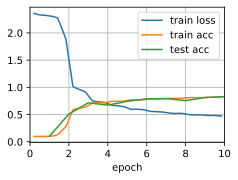

In [40]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)